<a href="https://colab.research.google.com/github/gulmert89/dsBootcamp/blob/master/project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graduation Project: Image Processing with Convolutional Neural Networks

Images of happy, shocked & sad faces.

---
# 1. Introduction

## 1.1 Importing Files & Modules

In [1]:
from google.colab import drive
drive.mount("/content/drive/")
%cd "/content/drive/My Drive/MertColab/project5/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/MertColab/project5


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, os, io
import cv2
from zipfile import ZipFile
from PIL import Image

In [3]:
shock_zip = ZipFile("shock.zip", "r")
happy_zip = ZipFile("happy.zip", "r")
sad_zip = ZipFile("sad.zip", "r")

In [4]:
shock_img = []
happy_img = []
sad_img = []
for var_zip, var_img in zip((shock_zip, happy_zip, sad_zip),
                          (shock_img, happy_img, sad_img)):
    for img_name in var_zip.namelist():
        byte_data = var_zip.read(img_name)
        img = io.BytesIO(byte_data)
        img = np.array(Image.open(img))
        img = cv2.resize(img, (128, 128))
        img = cv2.cvtColor(img, code=8) if len(img.shape) != 3 else img    #note
        var_img.append(img)
shock_img = np.asarray(shock_img)
happy_img = np.asarray(happy_img)
sad_img = np.asarray(sad_img)

In the "noted" line above, <code>code = 8</code> refers to <code>cv2.COLOR_GRAY2BGR</code> (see the [link](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html)).<br>This conversation is required since there are 8bpp images in the dataset. The rest is in 24bpp (RGB).

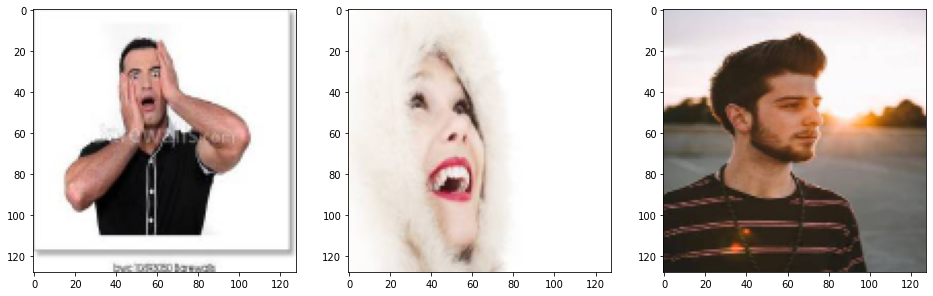

In [5]:
plt.figure(figsize=(16,12))
plt.subplot(1,3,1)
plt.imshow(shock_img[np.random.randint(0,150)])
plt.subplot(1,3,2)
plt.imshow(happy_img[np.random.randint(0,150)])
plt.subplot(1,3,3)
plt.imshow(sad_img[np.random.randint(0,150)])
plt.show()

We are going to create an **X_train** which will contain arrays of the images & a **y_train** to hold the label numbers. There will be some points that need to be paid close attention.

1) Both **X_train** & **y_train** will be sequential! First 180 images will belong to *sad* class, the second 180 is for the *shock* class and the last sequence corresponds to the *happy* people. Thus, while training the model (or even before), one should remember to shuffle the batches to avoid any obstacle on the learning path.

2) **y_train** has only numbers, which are **0**, **1** and **2**. These are the *sad*, *shocked* & *happy* classes, respectively.

3) About 100 images will be put aside for the test set. So there will be less than $3 * 180 = 540$ images in the train set. Numbers may change.

In [6]:
X_train = np.concatenate([sad_img, shock_img, happy_img], axis=0)
y_train = np.array([0]*180 + [1]*180 + [2]*180)
# in case of dimensional error:
# y_train = np.array([0]*180 + [1]*180 + [2]*180, ndmin=2).T

# 100 pictures in total were chosen for the test set
np.random.seed(42)
random_sad = np.random.choice(range(0, 180), 33, replace=False)
random_shock = np.random.choice(range(180, 360), 33, replace=False)
random_happy = np.random.choice(range(360, 540), 34, replace=False)
random_indices = np.concatenate([random_sad,
                                 random_shock,
                                 random_happy])

X_test = X_train[random_indices]
y_test = y_train[random_indices]
# let's remove the selected pictures from the train set
X_train = np.delete(X_train, random_indices, axis=0)
y_train = np.delete(y_train, random_indices, axis=0)

# ...and dispose of these temporary variables:
del random_sad, random_shock, random_happy, random_indices

# Do not forget to shuffle to deck:
def shuffle_set():
    # to make sure the shuffle is the same for both of them,
    random_state = np.random.get_state()
    np.random.shuffle(X_train)
    # we keep the random state and pass it to the next step:
    np.random.set_state(random_state)
    np.random.shuffle(y_train)
shuffle_set()

In [7]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

In [8]:
# https://keras.io/api/preprocessing/image/#imagedatagenerator-class
train_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=35,    # adjusted
    width_shift_range=0.20,    # adjusted
    height_shift_range=0.20,    # adjusted
    brightness_range=(0.75, 1.25),    # adjusted
    shear_range=0.20,    # adjusted
    zoom_range=0.20,    # adjusted
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,    # adjusted
    vertical_flip=False,
    rescale=1.0/255,    # adjusted
    preprocessing_function=None,
    data_format=None,
    validation_split=0.1,    # adjusted
    dtype=None,
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

Some example of generated pictures:

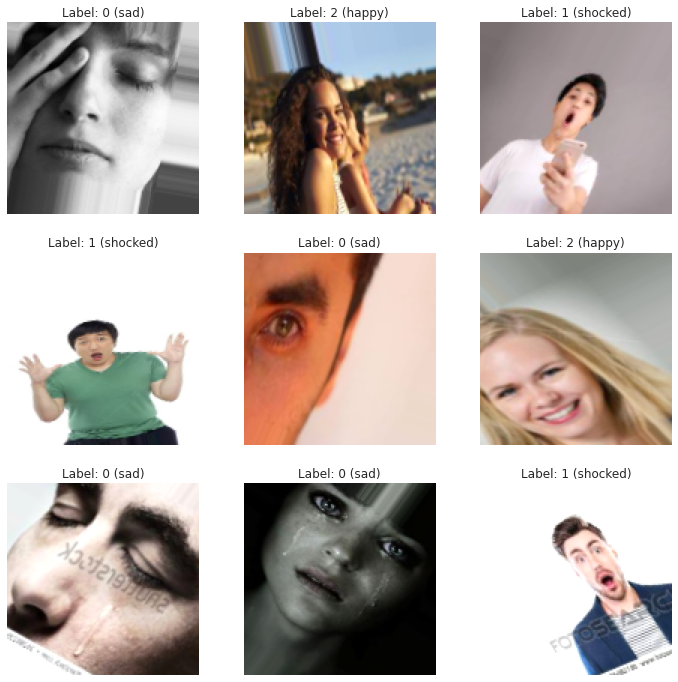

In [9]:
# https://keras.io/api/preprocessing/image/#flow-method
train_generator = train_datagen.flow(x=X_train, y=y_train, 
                                     batch_size=1, 
                                     shuffle=True, 
                                     sample_weight=None, 
                                     seed=None, 
                                     save_to_dir=None, 
                                     save_prefix="", 
                                     save_format="png", 
                                     subset="training",
                                     )
validation_generator = train_datagen.flow(x=X_train, y=y_train, 
                                     batch_size=1, 
                                     shuffle=True, 
                                     sample_weight=None, 
                                     seed=None, 
                                     subset="validation",
                                     )
test_generator = test_datagen.flow(x=X_test, y=y_test, 
                                     batch_size=1, 
                                     shuffle=True, 
                                     sample_weight=None, 
                                     seed=None,
                                     )
sns.set_style(style="white")
plt.figure(figsize=(12,12))
for i, picture in enumerate(train_generator):
    plt.subplot(3,3,i+1)
    plt.imshow(array_to_img(picture[0][0]))
    label_num = picture[1][0]
    label_str = "happy" if label_num==2 else "shocked" if label_num else "sad" 
    plt.title(f"Label: {label_num} ({label_str})")
    plt.axis("off")
    if i == 8:
        break
plt.show()

# 2. Creating The Model

In [10]:
from keras import models, layers

In [11]:
print("---Shape of the train set---\nX_train:", X_train.shape, 
      "\ny_train:", y_train.shape)
print("\n---Shape of the test set---\nX_test:", X_test.shape, 
      "\ny_test:", y_test.shape)

---Shape of the train set---
X_train: (440, 128, 128, 3) 
y_train: (440,)

---Shape of the test set---
X_test: (100, 128, 128, 3) 
y_test: (100,)


A Simple, Baseline Model

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.3))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(filters=256, 
#                         kernel_size=(3, 3),
#                         activation="relu"))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Conv2D(filters=16, 
#                         kernel_size=(3, 3),
#                         activation="relu"))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 127008)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                4064288   
_________________________________________________________________
Output_Layer (Dense)         (None, 3)                 99        
Total params: 4,065,283
Trainable params: 4,065,283
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer="adam", 
            loss="sparse_categorical_crossentropy", 
            metrics=["accuracy"])
# fit the set
model_history = model.fit(train_generator, 
                batch_size=2, 
                epochs=200, 
                steps_per_epoch = None,
                verbose=0, 
                validation_data=validation_generator
                )

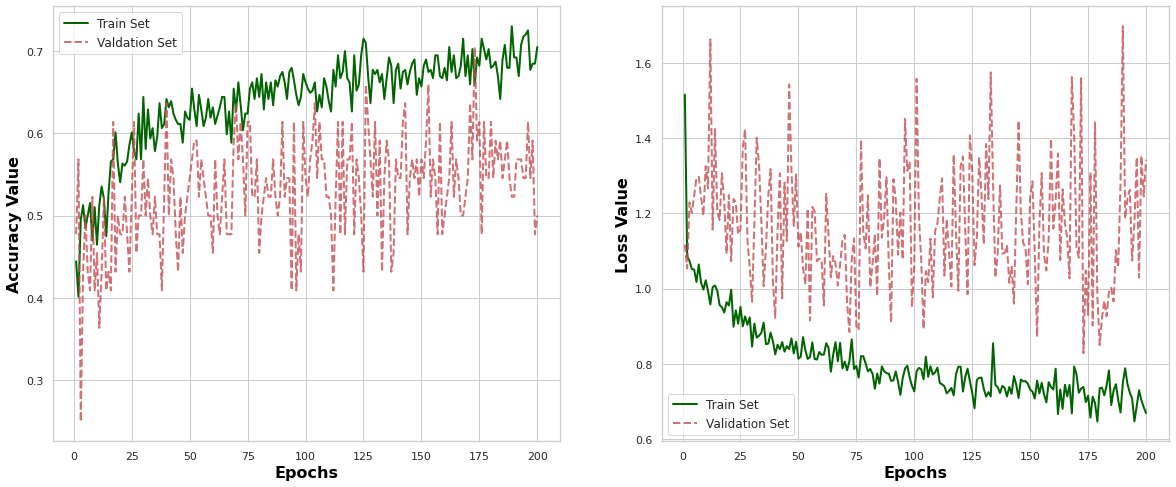

In [14]:
# cosmetic configuration
sns.set(style="whitegrid")
title_font = {"family":"sans", 
              "color":"darkred", 
              "size":30, 
              "weight":"bold", 
              "alpha":0.9}
axis_font = {"family":"sans-serif", 
              "color":"black", 
              "size":16, 
              "weight":"bold"}

# plot the graphs
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(range(1, len(model_history.history["accuracy"])+1), 
         model_history.history["accuracy"], 
         color="darkgreen", linewidth=2, label="Train Set")
plt.plot(range(1, len(model_history.history["val_accuracy"])+1), 
         model_history.history["val_accuracy"], 
         "r--", linewidth=2, label="Valdation Set", alpha=0.8)
plt.xlabel("Epochs", fontdict=axis_font)
plt.ylabel("Accuracy Value", fontdict=axis_font)
plt.legend(fontsize="medium", loc=0)

plt.subplot(1,2,2)
plt.plot(range(1, len(model_history.history["loss"])+1), 
         model_history.history["loss"], 
         color="darkgreen", linewidth=2, label="Train Set")
plt.plot(range(1, len(model_history.history["val_loss"])+1), 
         model_history.history["val_loss"], 
         "r--", linewidth=2, label="Validation Set", alpha=0.8)
plt.xlabel("Epochs", fontdict=axis_font)
plt.ylabel("Loss Value", fontdict=axis_font)
plt.legend(fontsize="medium", loc=0)

plt.show()